In [1]:
import pandas as pd
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
#from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import f1_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from scipy.stats import sem
import pingouin as pg
from scipy import stats
import scikit_posthocs as sp
import tensorflow as tf 
from tensorflow import keras
import easygui
import seaborn as sns
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
import matplotlib.ticker as ticker
OUTDATED_IGNORE=1
notnorm = True
import pickle
import itertools
import scipy.io
from xgboost import XGBClassifier
import os

C:\Users\gniew\anaconda3\envs\WORK\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


### Load data - 

In [2]:
# Difine pathways 
df = pd.read_excel("C:\\Users\\gniew\\Desktop\\PRACA\\Bio_fizyka\\merge_data.xlsx")
save_to = "C:/Users/gniew/Desktop/PRACA/Bio_fizyka/merge_model/"

In [3]:
df

Label  Area       Mean  \
0    PANC-1_Normoksja_19_48h_większa_konfluencja_po...   945  131.70159   
1    PANC-1_Normoksja_19_48h_większa_konfluencja_po...   621  133.32850   
2    PANC-1_Normoksja_19_48h_większa_konfluencja_po...   401  106.07481   
3    PANC-1_Normoksja_19_48h_większa_konfluencja_po...  1483  129.80580   
4    PANC-1_Normoksja_19_48h_większa_konfluencja_po...   461  128.24078   
..                                                 ...   ...        ...   
684  U87_Hipoksja_11_48h_większa_konfluencja_po_obr...  1931  140.09529   
685  U87_Hipoksja_11_48h_większa_konfluencja_po_obr...  1769  129.72244   
686  U87_Hipoksja_11_48h_większa_konfluencja_po_obr...  1980  108.94899   
687  U87_Hipoksja_11_48h_większa_konfluencja_po_obr...  2031  134.65239   
688  U87_Hipoksja_11_48h_większa_konfluencja_po_obr...   643  115.03266   

        Perim,    Circ,       AR    Round  Solidity    type  
0    141.98633  0.58905  1.14628  0.87239   0.76518  PANC-1  
1     98.86254  0.79843  1.26156  0.79267   0.90459  PANC-1  
2     75.10186  0.89341  1.43684  0.69597   0.94464  PANC-1  
3    186.61611  0.53512  1.88175  0.53142   0.83268  PANC-1  
4     87.44980  0.75752  1.53274  0.65243   0.91017  PANC-1  
..         ...      ...      ...      ...       ...     ...  
684  265.54736  0.34412  1.84868  0.54093   0.58648     U87  
685  241.85564  0.38004  1.85622  0.53873   0.61232     U87  
686  250.50970  0.39648  2.34645  0.42618   0.69437     U87  
687  213.02646  0.56241  2.39705  0.41718   0.86205     U87  
688  122.44735  0.53892  2.87139  0.34826   0.86951     U87  

[689 rows x 9 columns]

In [4]:
def normalize(data):
    scaler = MinMaxScaler()
    data_reshaped = np.array(data).reshape(-1, 1)
    scaler.fit(data_reshaped)
    data_norm = scaler.transform(data_reshaped)
    return scaler, data_norm

In [5]:
def re_normalize(scaler_list, feature_list, data):
    for scaler, feature in zip(scaler_list, feature_list):
        data_reshaped = np.array(data[feature]).reshape(-1, 1)
        data_norm = scaler.transform(data_reshaped)
        data[feature] = data_norm
    return data

#### DATA Enginering

In [6]:
df["Label"] = df["Label"].apply(lambda x: 1 if "hipo" in x.lower() else 0)

In [7]:
df["Label"].head()

0    0
1    0
2    0
3    0
4    0
Name: Label, dtype: int64

In [8]:
to_norm = list(df.columns)
to_norm.remove("Label")
to_norm.remove("type")
to_norm

['Area', 'Mean', 'Perim,', 'Circ,', 'AR', 'Round', 'Solidity']

In [9]:
scaler_list_new = []
for i in to_norm:
    scaler, data_norm = normalize(df[i])
    df[i] = data_norm
    scaler_list_new.append(scaler)

In [10]:
df.head()

Label      Area      Mean    Perim,     Circ,        AR     Round  \
0      0  0.071389  0.449133  0.165477  0.586960  0.011377  0.865965   
1      0  0.035078  0.467470  0.060783  0.850152  0.020598  0.779493   
2      0  0.010423  0.160305  0.003097  0.969543  0.034619  0.674603   
3      0  0.131682  0.427767  0.273828  0.519169  0.070207  0.496117   
4      0  0.017147  0.410128  0.033075  0.798728  0.042290  0.627375   

   Solidity    type  
0  0.678856  PANC-1  
1  0.899935  PANC-1  
2  0.963447  PANC-1  
3  0.785899  PANC-1  
4  0.908784  PANC-1

In [13]:
df["type"].unique()

array(['PANC-1', 'PANC-2', 'GL261', 'LN229', 'U87'], dtype=object)

### One Hot Encoding

In [14]:
df_encoded = pd.get_dummies(df, columns=["type", ])

In [15]:
df_encoded

Label      Area      Mean    Perim,     Circ,        AR     Round  \
0        0  0.071389  0.449133  0.165477  0.586960  0.011377  0.865965   
1        0  0.035078  0.467470  0.060783  0.850152  0.020598  0.779493   
2        0  0.010423  0.160305  0.003097  0.969543  0.034619  0.674603   
3        0  0.131682  0.427767  0.273828  0.519169  0.070207  0.496117   
4        0  0.017147  0.410128  0.033075  0.798728  0.042290  0.627375   
..     ...       ...       ...       ...       ...       ...       ...   
684      1  0.181889  0.543735  0.465455  0.279081  0.067561  0.506432   
685      1  0.163734  0.426827  0.407937  0.324233  0.068164  0.504046   
686      1  0.187381  0.192699  0.428947  0.344898  0.107378  0.381964   
687      1  0.193096  0.482391  0.337946  0.553473  0.111425  0.372201   
688      1  0.037543  0.261265  0.118041  0.523946  0.149367  0.297444   

     Solidity  type_GL261  type_LN229  type_PANC-1  type_PANC-2  type_U87  
0    0.678856           0           0            1            0         0  
1    0.899935           0           0            1            0         0  
2    0.963447           0           0            1            0         0  
3    0.785899           0           0            1            0         0  
4    0.908784           0           0            1            0         0  
..        ...         ...         ...          ...          ...       ...  
684  0.395471           0           0            0            0         1  
685  0.436448           0           0            0            0         1  
686  0.566565           0           0            0            0         1  
687  0.832474           0           0            0            0         1  
688  0.844305           0           0            0            0         1  

[689 rows x 13 columns]

In [16]:
df_encoded =df_encoded.sample(frac=1)

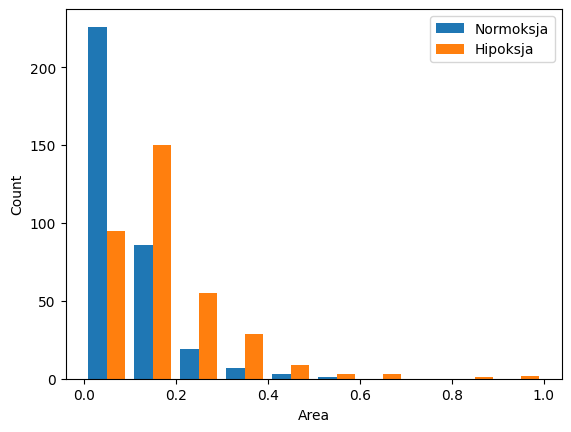

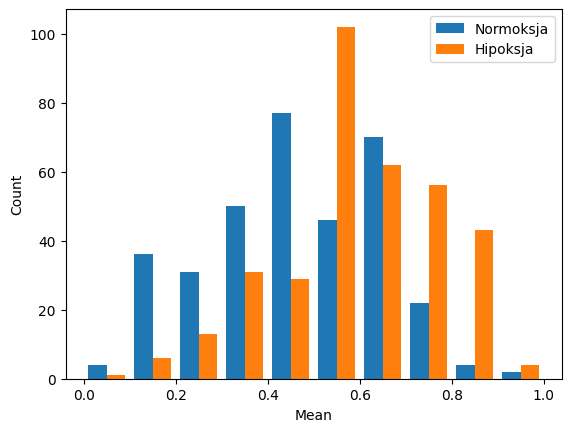

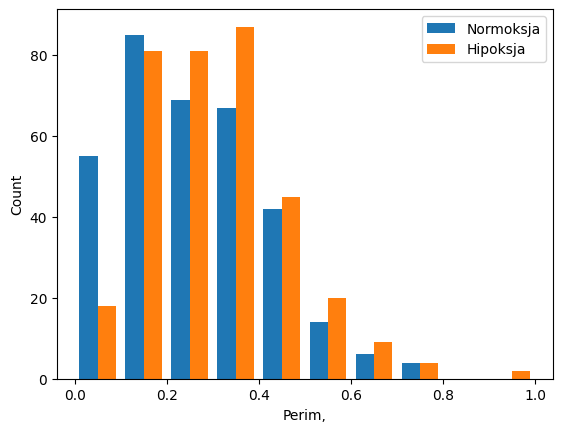

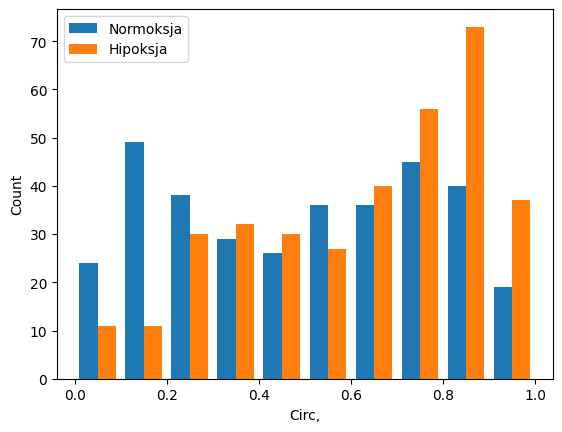

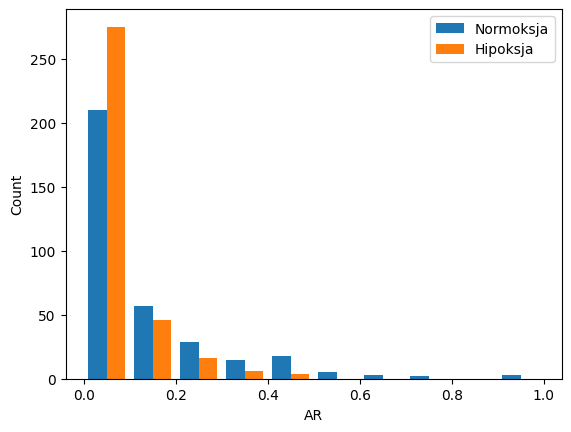

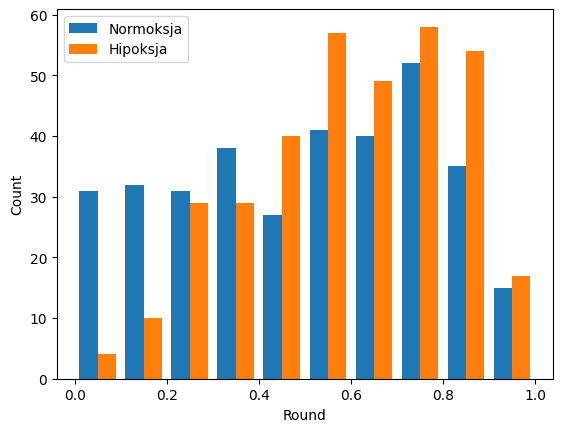

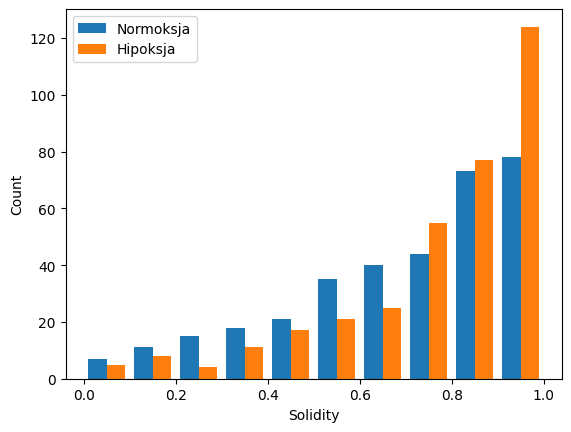

In [17]:
for i in to_norm:
    ans_1 = df_encoded.loc[df["Label"] == 0, i]
    ans_2 = df_encoded.loc[df["Label"] == 1, i]
    plt.hist([ans_1, ans_2], label = ["Normoksja", "Hipoksja"])
    plt.legend()
    plt.xlabel(i)
    plt.ylabel("Count")
    plt.show()

### DATA SPLIT 

In [26]:
y = df_encoded["Label"]
X = df_encoded.drop("Label",  axis = 1)

random_state = 6
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, train_size = 0.7, stratify= y)

X_train = X_train.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
X_test = X_test.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
features_ = list(X_train.columns)

### Supporter Vector Clasifier

{'0': {'precision': 0.9230769230769231, 'recall': 0.9320388349514563, 'f1-score': 0.927536231884058, 'support': 103}, '1': {'precision': 0.9320388349514563, 'recall': 0.9230769230769231, 'f1-score': 0.927536231884058, 'support': 104}, 'accuracy': 0.927536231884058, 'macro avg': {'precision': 0.9275578790141897, 'recall': 0.9275578790141897, 'f1-score': 0.927536231884058, 'support': 207}, 'weighted avg': {'precision': 0.9275795261443214, 'recall': 0.927536231884058, 'f1-score': 0.927536231884058, 'support': 207}}
y_test: [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1,

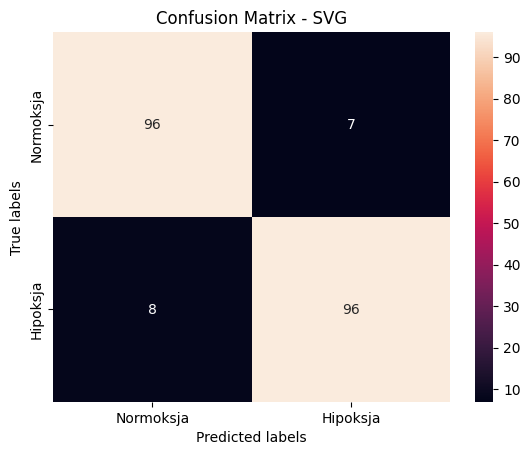

In [27]:
param_grid = [{"C": [0.5, 1, 10, 100],
              "gamma": ["scale", 1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["linear", "poly", "rbf"]},
]
optimal_params = GridSearchCV(SVC(),
                             param_grid,
                             cv=10,
                             scoring = "accuracy")
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)
best_clf = optimal_params.fit(X_train_scaled, y_train)
parameters= best_clf.best_params_
parameters= list(parameters.values())

model = SVC(C = parameters[0], gamma = parameters[1], kernel = parameters[2])
model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)
raport = classification_report(y_test,y_pred,output_dict = True)
print(raport)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)
print(f"y_test: {list(y_test)},  y_pred: {y_pred}")
perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats = 15, scoring = "accuracy")
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - SVG')
ax.xaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
ax.yaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
plt.savefig(save_to + "/SVC_test.svg")
plt.show()

In [28]:
index_X_test = X_test.index[X_test["type_PANC-1"] == 1].tolist()
PANC_1_y_test = y_test[index_X_test]
PANC_1_X_test = X_test.reset_index(drop = True)
PANC_1_y_pred = y_pred[X_test["type_PANC-1"] == 1]

{'0': {'precision': 0.9210526315789473, 'recall': 0.8536585365853658, 'f1-score': 0.8860759493670887, 'support': 41}, '1': {'precision': 0.85, 'recall': 0.918918918918919, 'f1-score': 0.8831168831168831, 'support': 37}, 'accuracy': 0.8846153846153846, 'macro avg': {'precision': 0.8855263157894737, 'recall': 0.8862887277521424, 'f1-score': 0.8845964162419859, 'support': 78}, 'weighted avg': {'precision': 0.8873481781376518, 'recall': 0.8846153846153846, 'f1-score': 0.8846722897355809, 'support': 78}}
y_test: [1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 

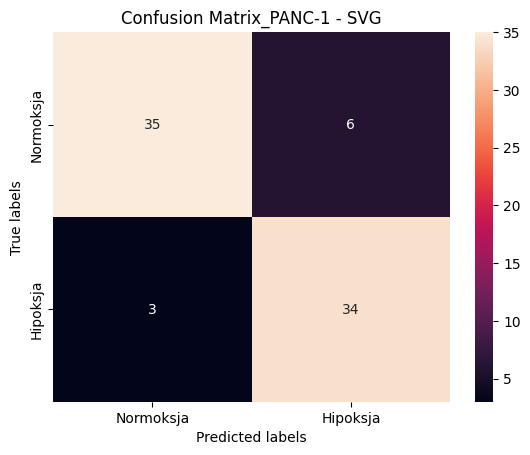

In [29]:
raport = classification_report(PANC_1_y_test, PANC_1_y_pred,output_dict = True)
print(raport)
conf_matrix = confusion_matrix(y_true=PANC_1_y_test, y_pred=PANC_1_y_pred)
print(f"y_test: {list(y_test)},  y_pred: {y_pred}")
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix_PANC-1 - SVG')
ax.xaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
ax.yaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
plt.savefig(save_to + "/SVC_test_type_PANC-1.svg")
plt.show()

In [30]:
index_X_test = X_test.index[X_test["type_PANC-2"] == 1].tolist()
PANC_2_y_test = y_test[index_X_test]
PANC_2_X_test = X_test.reset_index(drop = True)
PANC_2_y_pred = y_pred[X_test["type_PANC-2"] == 1]

{'0': {'precision': 0.7916666666666666, 'recall': 0.95, 'f1-score': 0.8636363636363635, 'support': 20}, '1': {'precision': 0.9473684210526315, 'recall': 0.782608695652174, 'f1-score': 0.8571428571428571, 'support': 23}, 'accuracy': 0.8604651162790697, 'macro avg': {'precision': 0.8695175438596491, 'recall': 0.866304347826087, 'f1-score': 0.8603896103896103, 'support': 43}, 'weighted avg': {'precision': 0.8749490004079966, 'recall': 0.8604651162790697, 'f1-score': 0.8601630927212321, 'support': 43}}


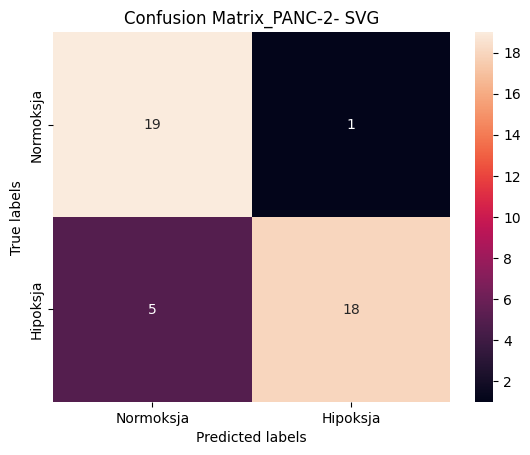

In [31]:
raport = classification_report(PANC_2_y_test, PANC_2_y_pred,output_dict = True)
print(raport)
conf_matrix = confusion_matrix(y_true=PANC_2_y_test, y_pred=PANC_2_y_pred)
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix_PANC-2- SVG')
ax.xaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
ax.yaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
plt.savefig(save_to + "/SVC_test_type_PANC_2.svg")
plt.show()

In [32]:
index_X_test = X_test.index[X_test["type_GL261"] == 1].tolist()
GL261_y_test = y_test[index_X_test]
GL261_X_test = X_test.reset_index(drop = True)
GL261_y_pred = y_pred[X_test["type_GL261"] == 1]

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 13}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 18}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 31}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 31}}


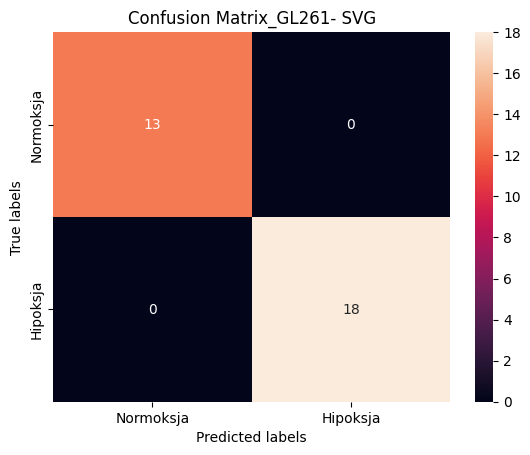

In [33]:
raport = classification_report(GL261_y_test, GL261_y_pred,output_dict = True)
print(raport)
conf_matrix = confusion_matrix(y_true=GL261_y_test, y_pred=GL261_y_pred)
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix_GL261- SVG')
ax.xaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
ax.yaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
plt.savefig(save_to + "/SVC_test_type_GL261.svg")
plt.show()

In [34]:
index_X_test = X_test.index[X_test["type_LN229"] == 1].tolist()
LN229_y_test = y_test[index_X_test]
LN229_X_test = X_test.reset_index(drop = True)
LN229_y_pred = y_pred[X_test["type_LN229"] == 1]

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 17}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 34}}


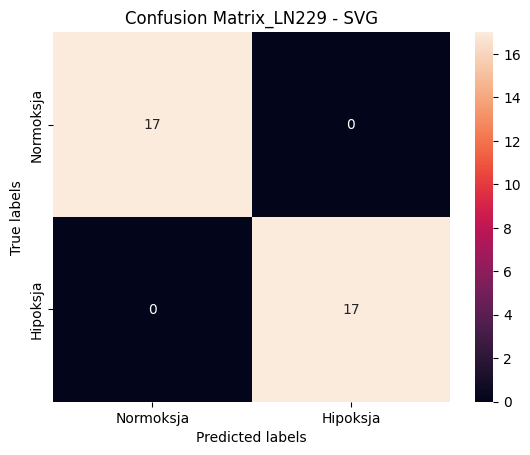

In [35]:
raport = classification_report(LN229_y_test, LN229_y_pred,output_dict = True)
print(raport)
conf_matrix = confusion_matrix(y_true=LN229_y_test, y_pred=LN229_y_pred)
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix_LN229 - SVG')
ax.xaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
ax.yaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
plt.savefig(save_to + "/SVC_test_type_LN229.svg")
plt.show()

In [38]:
index_X_test = X_test.index[X_test["type_U87"] == 1].tolist()
U87_y_test = y_test[index_X_test]
U87_X_test = X_test.reset_index(drop = True)
U87_y_pred = y_pred[X_test["type_U87"] == 1]

{'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 12}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 9}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 21}}


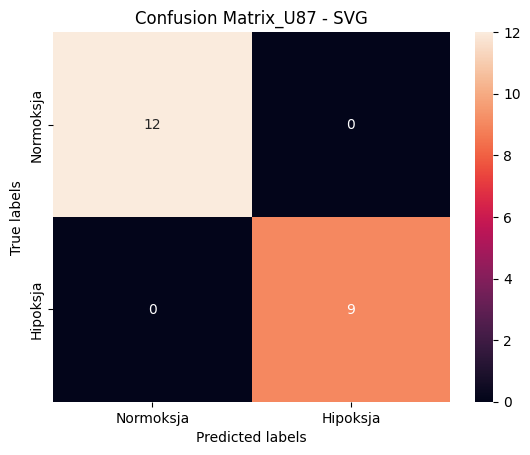

In [39]:
raport = classification_report(U87_y_test, U87_y_pred,output_dict = True)
print(raport)
conf_matrix = confusion_matrix(y_true=U87_y_test, y_pred=U87_y_pred)
fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix_U87 - SVG')
ax.xaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
ax.yaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
plt.savefig(save_to + "/SVC_test_type_U87.svg")
plt.show()

In [36]:
# Save report result 
df_SVG_test = pd.DataFrame(raport)
df_SVG_test = df_SVG_test.transpose()
df_SVG_test.to_excel(save_to + "/SVC_test.xlsx")

In [37]:
list(zip(features_ ,perm_importance.get("importances_mean")))

[('Area', 0.061513687600644136),
 ('Perim,', 0.03671497584541064),
 ('Circ,', 0.06666666666666667),
 ('AR', 0.018357487922705338),
 ('Round', 0.055394524959742356),
 ('Solidity', 0.026409017713365568),
 ('Mean', 0.31497584541062806),
 ('type_GL261', 0.06827697262479873),
 ('type_LN229', 0.07729468599033816),
 ('type_PANC-1', 0.048631239935587774),
 ('type_PANC-2', 0.0930756843800322),
 ('type_U87', 0.04991948470209342)]

In [16]:
kf = KFold(n_splits=10, shuffle=True)

acc_arr = np.empty((10, 1))
recall_arr = np.empty((10, 1))
recall_arr_normo = np.empty((10,1))
recall_arr_hipo = np.empty((10,1))

precision_arr = np.empty((10,1))
precision_arr_normo = np.empty((10,1))
precision_arr_hipo = np.empty((10,1))

f1_arr = np.empty((10, 1))
f1_arr_normo = np.empty((10,1))
f1_arr_hipo = np.empty((10,1))

df_modeling_summary = pd.DataFrame(index = [1,2,3,4,5], columns = ["model", "accuracy_avg", "accuracy_sem", "f1-score_avg", "f1-score_sem", "f1-score_normo", "f1-score_hipo", "recall_avg", "recall_sem", "recall_normo", "recall_hipo", "precision_avg", "precision_sem", "precision_normo", "precision_hipo"])
df_feature_importance = pd.DataFrame(index = [1,2,3,4,5], columns = ["model", "area_avg", "area_sem",  "perim_avg", "perim_sem", "circ_avg", "circ_sem", "ar_avg", "ar_sem", "round_avg", "round_sem", "solidity_avg", "solidity_sem", "mean_avg", "mean_sem", "type_GL261_avg", "type_GL261_sem", "type_LN229_avg", "type_LN229_sem","type_PANC-1_avg","type_PANC-1_sem", "type_PANC-2_avg", "type_PANC-2_sem", "type_U87_avg", "type_U87_sem"])

area_arr = np.empty((10, 1))
perim_arr = np.empty((10, 1))
circ_arr = np.empty((10, 1))
ar_arr = np.empty((10, 1))
round_arr = np.empty((10, 1))
solidity_arr = np.empty((10, 1))
mean_arr = np.empty((10, 1))
type_GL261_arr = np.empty((10, 1))
type_LN229_arr = np.empty((10, 1))
type_PANC_1_arr = np.empty((10, 1))
type_PANC_2_arr = np.empty((10, 1))
type_U87_arr = np.empty((10, 1))

In [ ]:
param_grid = [{"C": [0.5, 1, 10, 100],
              "gamma": ["scale", 1, 0.1, 0.01, 0.001, 0.0001],
              "kernel": ["linear", "poly", "rbf"]},
]

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    optimal_params = GridSearchCV(SVC(),
                                 param_grid,
                                 cv=10,
                                 scoring = "accuracy")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    X_train = X_train.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
    X_test = X_test.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
    
    X_train_scaled = scale(X_train)
    X_test_scaled = scale(X_test)
    best_clf = optimal_params.fit(X_train_scaled, y_train)
    parameters= best_clf.best_params_
    print(parameters)
    parameters = list(parameters.values())
    model = SVC(C = parameters[0], gamma = parameters[1], kernel = parameters[2])
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats = 15, scoring = "accuracy")
    
    acc_arr[i] = accuracy_score(y_test, y_pred)
    precision_arr[i] = precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)
    f1_arr[i] = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)
    recall_arr[i] =recall_score(y_test, y_pred,  average='weighted')
    
    raport = classification_report(y_test,y_pred,output_dict=True, zero_division=0)
    
    values_normo= list(raport["0"].values())
    precision_arr_normo[i] = values_normo[0]
    recall_arr_normo[i] = values_normo[1]
    f1_arr_normo[i] = values_normo[2]
    
    values_hipo= list(raport["1"].values())
    precision_arr_hipo[i] = values_hipo[0] 
    recall_arr_hipo[i] = values_hipo[1]
    f1_arr_hipo[i] = values_hipo[2]
    
    area_arr[i] = perm_importance.get("importances_mean")[0]
    perim_arr[i] = perm_importance.get("importances_mean")[1]
    circ_arr[i] = perm_importance.get("importances_mean")[2]
    ar_arr[i] = perm_importance.get("importances_mean")[3]
    round_arr[i] = perm_importance.get("importances_mean")[4]
    solidity_arr[i] = perm_importance.get("importances_mean")[5]
    mean_arr[i] = perm_importance.get("importances_mean")[6]
    type_GL261_arr[i] = perm_importance.get("importances_mean")[7]
    type_LN229_arr[i] = perm_importance.get("importances_mean")[8]
    type_PANC_1_arr[i] = perm_importance.get("importances_mean")[9]
    type_PANC_2_arr[i] = perm_importance.get("importances_mean")[10]
    type_U87_arr[i] = perm_importance.get("importances_mean")[11]
    
    
    
    print(f"Fold {i+1}/{acc_arr.shape[0]}")
    print(f"y_test: {list(y_test)},  y_pred: {y_pred}")
    print(list(zip(features_ ,perm_importance.get("importances_mean"))))
    values_weighted_avg = list(raport["weighted avg"].values())
    
    

precision_arr = precision_arr[precision_arr != 0]
precision_arr_normo = precision_arr_normo[precision_arr_normo != 0]
precision_arr_hipo = precision_arr_hipo[precision_arr_hipo != 0]

f1_arr = f1_arr[f1_arr != 0]
f1_arr_normo = f1_arr_normo[f1_arr_normo != 0]
f1_arr_hipo = f1_arr_hipo[f1_arr_hipo != 0]

list_SVG = ["SVG", round(acc_arr.mean(),2), round(float(sem(acc_arr)),2), round(f1_arr.mean(),2), round(float(sem(f1_arr)),2), round(f1_arr_normo.mean(),2), round(f1_arr_hipo.mean(),2), round(recall_arr.mean(),2), round(float(sem(recall_arr)),2), round(recall_arr_normo.mean(),2), round(recall_arr_hipo.mean(),2), round(precision_arr.mean(),2), round(float(sem(precision_arr)),2), round(precision_arr_normo.mean(),2), round(precision_arr_hipo.mean(),2)]

list_SVG_features = [ "SVG", round(area_arr.mean(), 2),  round(float(sem(area_arr)),2), round(perim_arr.mean(), 2),  round(float(sem(perim_arr)),2), round(circ_arr.mean(), 2),  round(float(sem(circ_arr)),2), round(ar_arr.mean(), 2),  round(float(sem(ar_arr)),2), round(round_arr.mean(), 2),  round(float(sem(round_arr)),2),  round(solidity_arr.mean(), 2),  round(float(sem(solidity_arr)),2), round(mean_arr.mean(), 2),  round(float(sem(mean_arr)),2),
                    round(type_GL261_arr.mean(), 2),  round(float(sem(type_GL261_arr)),2), round(type_LN229_arr.mean(), 2),  round(float(sem(type_LN229_arr)),2),round(type_PANC_1_arr.mean(), 2),  round(float(sem(type_PANC_1_arr)),2),round(type_PANC_2_arr.mean(), 2),  round(float(sem(type_PANC_2_arr)),2),round(type_U87_arr.mean(), 2),  round(float(sem(type_U87_arr)),2)]

df_modeling_summary.loc[1] = list_SVG
df_feature_importance.loc[1] = list_SVG_features

df_modeling_summary

In [ ]:
for i in type_U87_arr:
    print(i[0])

### Logistic Regression 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, train_size = 0.7, stratify= y)
X_train = X_train.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
X_test = X_test.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
features_ = list(X_train.columns)

In [ ]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [ 5, 10,20, 50 ,100, 1000,2500]
    }
]

clf = GridSearchCV(LogisticRegression(), 
                       param_grid = param_grid, 
                       cv = 10, 
                       verbose=True, n_jobs=-1, 
                       scoring = "accuracy")

best_clf = clf.fit(X_train, y_train)
parameters= best_clf.best_params_
print(parameters)
parameters= list(parameters.values())

logModel = LogisticRegression(C =  parameters[0], max_iter = parameters[1], penalty = parameters[2], solver = parameters[3])
logModel.fit(X_train, y_train)
y_pred = logModel.predict(X_test)
raport = classification_report(y_test,y_pred,output_dict = True)
print(raport)
conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Logistic_Regression')
ax.xaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
ax.yaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
plt.savefig(save_to + "/Log_test.svg")
plt.show()

In [ ]:
# Save report result 
df_log_test = pd.DataFrame(raport)
df_log_test = df_log_test.transpose()
df_log_test.to_excel(save_to + "/Log_test.xlsx")

#### Cross validation 

In [ ]:
kf = KFold(n_splits=10, shuffle=True)

acc_arr = np.empty((10, 1))
recall_arr = np.empty((10, 1))
recall_arr_normo = np.empty((10,1))
recall_arr_hipo = np.empty((10,1))

precision_arr = np.empty((10,1))
precision_arr_normo = np.empty((10,1))
precision_arr_hipo = np.empty((10,1))

f1_arr = np.empty((10, 1))
f1_arr_normo = np.empty((10,1))
f1_arr_hipo = np.empty((10,1))

area_arr = np.empty((10, 1))
perim_arr = np.empty((10, 1))
circ_arr = np.empty((10, 1))
ar_arr = np.empty((10, 1))
round_arr = np.empty((10, 1))
solidity_arr = np.empty((10, 1))
mean_arr = np.empty((10, 1))
type_GL261_arr = np.empty((10, 1))
type_LN229_arr = np.empty((10, 1))
type_PANC_1_arr = np.empty((10, 1))
type_PANC_2_arr = np.empty((10, 1))
type_U87_arr = np.empty((10, 1))

In [ ]:
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet', 'none'],
    'C' : np.logspace(-4, 4, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'max_iter' : [ 5, 10,20, 50 ,100, 1000,2500]
    }
]

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    clf = GridSearchCV(LogisticRegression(), 
                       param_grid = param_grid, 
                       cv = 10, 
                       verbose=True, n_jobs=-1, 
                       scoring = "accuracy")
    
    
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    X_train = X_train.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
    X_test = X_test.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
    
    
    best_clf = clf.fit(X_train, y_train)
    parameters= best_clf.best_params_
    print(parameters)
    parameters= list(parameters.values())
    logModel = LogisticRegression(C =  parameters[0], max_iter = parameters[1], penalty = parameters[2], solver = parameters[3])
    logModel.fit(X_train, y_train)
    y_pred = logModel.predict(X_test)
    
    acc_arr[i] = accuracy_score(y_test, y_pred)
    precision_arr[i] = precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)
    f1_arr[i] = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)
    recall_arr[i] =recall_score(y_test, y_pred,  average='weighted')
    perm_importance = permutation_importance(logModel, X_test, y_test, n_repeats = 15, scoring = "accuracy")
    raport = classification_report(y_test,y_pred,output_dict=True, zero_division=0)
    
    values_normo= list(raport["0"].values())
    precision_arr_normo[i] = values_normo[0]
    recall_arr_normo[i] = values_normo[1]
    f1_arr_normo[i] = values_normo[2]
    
    values_hipo= list(raport["1"].values())
    precision_arr_hipo[i] = values_hipo[0] 
    recall_arr_hipo[i] = values_hipo[1]
    f1_arr_hipo[i] = values_hipo[2]
    print(f"Fold {i+1}/{acc_arr.shape[0]}")
    print(f"y_test: {list(y_test)},  y_pred: {y_pred}")
    values_weighted_avg = list(raport["weighted avg"].values())
    
    area_arr[i] = perm_importance.get("importances_mean")[0]
    perim_arr[i] = perm_importance.get("importances_mean")[1]
    circ_arr[i] = perm_importance.get("importances_mean")[2]
    ar_arr[i] = perm_importance.get("importances_mean")[3]
    round_arr[i] = perm_importance.get("importances_mean")[4]
    solidity_arr[i] = perm_importance.get("importances_mean")[5]
    mean_arr[i] = perm_importance.get("importances_mean")[6]
    type_GL261_arr[i] = perm_importance.get("importances_mean")[7]
    type_LN229_arr[i] = perm_importance.get("importances_mean")[8]
    type_PANC_1_arr[i] = perm_importance.get("importances_mean")[9]
    type_PANC_2_arr[i] = perm_importance.get("importances_mean")[10]
    type_U87_arr[i] = perm_importance.get("importances_mean")[11]
    
    
    

precision_arr = precision_arr[precision_arr != 0]
precision_arr_normo = precision_arr_normo[precision_arr_normo != 0]
precision_arr_hipo = precision_arr_hipo[precision_arr_hipo != 0]

f1_arr = f1_arr[f1_arr != 0]
f1_arr_normo = f1_arr_normo[f1_arr_normo != 0]
f1_arr_hipo = f1_arr_hipo[f1_arr_hipo != 0]

list_Log = ["Logistic_Regression", round(acc_arr.mean(),2), round(float(sem(acc_arr)),2), round(f1_arr.mean(),2), round(float(sem(f1_arr)),2), round(f1_arr_normo.mean(),2), round(f1_arr_hipo.mean(),2), round(recall_arr.mean(),2), round(float(sem(recall_arr)),2), round(recall_arr_normo.mean(),2), round(recall_arr_hipo.mean(),2), round(precision_arr.mean(),2), round(float(sem(precision_arr)),2), round(precision_arr_normo.mean(),2), round(precision_arr_hipo.mean(),2)]

list_Log_features = [ "Logistic_Regression", round(area_arr.mean(), 2),  round(float(sem(area_arr)),2), round(perim_arr.mean(), 2),  round(float(sem(perim_arr)),2), round(circ_arr.mean(), 2),  round(float(sem(circ_arr)),2), round(ar_arr.mean(), 2),  round(float(sem(ar_arr)),2), round(round_arr.mean(), 2),  round(float(sem(round_arr)),2),  round(solidity_arr.mean(), 2),  round(float(sem(solidity_arr)),2), round(mean_arr.mean(), 2),  round(float(sem(mean_arr)),2),
                    round(type_GL261_arr.mean(), 2),  round(float(sem(type_GL261_arr)),2), round(type_LN229_arr.mean(), 2),  round(float(sem(type_LN229_arr)),2),round(type_PANC_1_arr.mean(), 2),  round(float(sem(type_PANC_1_arr)),2),round(type_PANC_2_arr.mean(), 2),  round(float(sem(type_PANC_2_arr)),2),round(type_U87_arr.mean(), 2),  round(float(sem(type_U87_arr)),2)]



df_modeling_summary.loc[2] = list_Log
df_feature_importance.loc[2] = list_Log_features

In [ ]:
for i in type_U87_arr:
    print(i[0])

In [ ]:
df_modeling_summary

In [ ]:
df_feature_importance.iloc[:,10:]

### Random Forest

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, train_size = 0.7, stratify= y)
X_train = X_train.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
X_test = X_test.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
features_ = list(X_train.columns)

In [ ]:
param_grid = [{ 
    'n_estimators': [10, 100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2,4,5,6,7,8, 10],
    'criterion' :['gini', 'entropy']
}]
clf = GridSearchCV(RandomForestClassifier(), 
                       param_grid = param_grid, 
                       cv = 10, 
                       verbose=True, n_jobs=-1, 
                       scoring = "accuracy")

best_clf = clf.fit(X_train, y_train)
parameters= best_clf.best_params_
print(parameters)
parameters= list(parameters.values())
rfcModel = RandomForestClassifier(criterion=  parameters[0], max_depth = parameters[1], max_features= parameters[2], n_estimators= parameters[3])
rfcModel.fit(X_train, y_train)
y_pred = rfcModel.predict(X_test)

raport = classification_report(y_test, y_pred, output_dict = True)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)




fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Random_Forest_Classifier')
ax.xaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
ax.yaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
plt.savefig(save_to + "/Rfc_test.svg")
plt.show()

In [ ]:
# Save report result 
df_Rfc_test = pd.DataFrame(raport)
df_Rfc_test = df_Rfc_test.transpose()
df_Rfc_test.to_excel(save_to + "/Rfc_test.xlsx")

In [ ]:
kf = KFold(n_splits=10, shuffle=True)

acc_arr = np.empty((10, 1))
recall_arr = np.empty((10, 1))
recall_arr_normo = np.empty((10,1))
recall_arr_hipo = np.empty((10,1))

precision_arr = np.empty((10,1))
precision_arr_normo = np.empty((10,1))
precision_arr_hipo = np.empty((10,1))

f1_arr = np.empty((10, 1))
f1_arr_normo = np.empty((10,1))
f1_arr_hipo = np.empty((10,1))

area_arr = np.empty((10, 1))
perim_arr = np.empty((10, 1))
circ_arr = np.empty((10, 1))
ar_arr = np.empty((10, 1))
round_arr = np.empty((10, 1))
solidity_arr = np.empty((10, 1))
mean_arr = np.empty((10, 1))
type_GL261_arr = np.empty((10, 1))
type_LN229_arr = np.empty((10, 1))
type_PANC_1_arr = np.empty((10, 1))
type_PANC_2_arr = np.empty((10, 1))
type_U87_arr = np.empty((10, 1))

In [ ]:
 param_grid = [{ 
    'n_estimators': [1, 10, 100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [1, 2,4,5,6,7,8, 10],
    'criterion' :['gini', 'entropy']
}]

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    clf = GridSearchCV(RandomForestClassifier(), 
                       param_grid = param_grid, 
                       cv = 10, 
                       verbose=True, n_jobs=-1, 
                       scoring = "accuracy")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #X_test.drop("Mean", inplace = True, axis = 1)
    #X_train.drop("Mean", inplace = True, axis = 1)
    X_train = X_train.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
    X_test = X_test.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
    
    best_clf = clf.fit(X_train, y_train)
    parameters= best_clf.best_params_
    print(parameters)
    parameters= list(parameters.values())
    rfcModel = RandomForestClassifier(criterion=  parameters[0], max_depth = parameters[1], max_features= parameters[2], n_estimators= parameters[3])
    rfcModel.fit(X_train, y_train)
    y_pred = rfcModel.predict(X_test)
    perm_importance = permutation_importance(rfcModel, X_test, y_test, n_repeats = 15, scoring = "accuracy")
    
    acc_arr[i] = accuracy_score(y_test, y_pred)
    precision_arr[i] = precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)
    f1_arr[i] = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)
    recall_arr[i] =recall_score(y_test, y_pred,  average='weighted')
    
    raport = classification_report(y_test,y_pred,output_dict=True, zero_division=0)
    
    values_normo= list(raport["0"].values())
    precision_arr_normo[i] = values_normo[0]
    recall_arr_normo[i] = values_normo[1]
    f1_arr_normo[i] = values_normo[2]
    
    values_hipo= list(raport["1"].values())
    precision_arr_hipo[i] = values_hipo[0] 
    recall_arr_hipo[i] = values_hipo[1]
    f1_arr_hipo[i] = values_hipo[2]
    print(f"Fold {i+1}/{acc_arr.shape[0]}")
    print(f"y_test: {list(y_test)},  y_pred: {y_pred}")
    values_weighted_avg = list(raport["weighted avg"].values())
    
    area_arr[i] = perm_importance.get("importances_mean")[0]
    perim_arr[i] = perm_importance.get("importances_mean")[1]
    circ_arr[i] = perm_importance.get("importances_mean")[2]
    ar_arr[i] = perm_importance.get("importances_mean")[3]
    round_arr[i] = perm_importance.get("importances_mean")[4]
    solidity_arr[i] = perm_importance.get("importances_mean")[5]
    mean_arr[i] = perm_importance.get("importances_mean")[6]
    type_GL261_arr[i] = perm_importance.get("importances_mean")[7]
    type_LN229_arr[i] = perm_importance.get("importances_mean")[8]
    type_PANC_1_arr[i] = perm_importance.get("importances_mean")[9]
    type_PANC_2_arr[i] = perm_importance.get("importances_mean")[10]
    type_U87_arr[i] = perm_importance.get("importances_mean")[11]
    

precision_arr = precision_arr[precision_arr != 0]
precision_arr_normo = precision_arr_normo[precision_arr_normo != 0]
precision_arr_hipo = precision_arr_hipo[precision_arr_hipo != 0]

f1_arr = f1_arr[f1_arr != 0]
f1_arr_normo = f1_arr_normo[f1_arr_normo != 0]
f1_arr_hipo = f1_arr_hipo[f1_arr_hipo != 0]

list_rfcModel = ["Random_Forest_Classifier", round(acc_arr.mean(),2), round(float(sem(acc_arr)),2), round(f1_arr.mean(),2), round(float(sem(f1_arr)),2), round(f1_arr_normo.mean(),2), round(f1_arr_hipo.mean(),2), round(recall_arr.mean(),2), round(float(sem(recall_arr)),2), round(recall_arr_normo.mean(),2), round(recall_arr_hipo.mean(),2), round(precision_arr.mean(),2), round(float(sem(precision_arr)),2), round(precision_arr_normo.mean(),2), round(precision_arr_hipo.mean(),2)]

list_rfcModel_features = ["Random_Forest_Classifier", round(area_arr.mean(), 2),  round(float(sem(area_arr)),2), round(perim_arr.mean(), 2),  round(float(sem(perim_arr)),2), round(circ_arr.mean(), 2),  round(float(sem(circ_arr)),2), round(ar_arr.mean(), 2),  round(float(sem(ar_arr)),2), round(round_arr.mean(), 2),  round(float(sem(round_arr)),2),  round(solidity_arr.mean(), 2),  round(float(sem(solidity_arr)),2), round(mean_arr.mean(), 2),  round(float(sem(mean_arr)),2),
                    round(type_GL261_arr.mean(), 2),  round(float(sem(type_GL261_arr)),2), round(type_LN229_arr.mean(), 2),  round(float(sem(type_LN229_arr)),2),round(type_PANC_1_arr.mean(), 2),  round(float(sem(type_PANC_1_arr)),2),round(type_PANC_2_arr.mean(), 2),  round(float(sem(type_PANC_2_arr)),2),round(type_U87_arr.mean(), 2),  round(float(sem(type_U87_arr)),2)]

df_feature_importance.loc[3] = list_rfcModel_features
df_modeling_summary.loc[3] = list_rfcModel


In [ ]:
for i in type_U87_arr:
    print(i[0])

In [ ]:

df_modeling_summary

### Neural Network

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, train_size = 0.7, stratify = y)


X_train = X_train.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
X_test = X_test.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
features_ = list(X_train.columns)

In [ ]:

NN_model = keras.Sequential([
    keras.layers.Dense(16, input_shape = (X_train.shape[1],), activation = "relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(20, activation = "relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation = "sigmoid"),
])
NN_model.compile(optimizer = "adam",
             loss= 'binary_crossentropy',
             metrics = ["accuracy"])
NN_model.fit(X_train, y_train, epochs = 5000)

In [ ]:
X_train

In [ ]:
NN_model.evaluate(X_test, y_test)

In [ ]:
y_pred = NN_model.predict(X_test)
y_pred = y_pred > 0.6
y_pred = y_pred.astype(int)
raport = classification_report(y_test,y_pred,output_dict = False)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)

fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Neural Network')
ax.xaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
ax.yaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
plt.savefig(save_to + "/NN_test.svg")
plt.show()

In [17]:
kf = KFold(n_splits=10, shuffle=True)

acc_arr = np.empty((10, 1))
recall_arr = np.empty((10, 1))
recall_arr_normo = np.empty((10,1))
recall_arr_hipo = np.empty((10,1))

precision_arr = np.empty((10,1))
precision_arr_normo = np.empty((10,1))
precision_arr_hipo = np.empty((10,1))

f1_arr = np.empty((10, 1))
f1_arr_normo = np.empty((10,1))
f1_arr_hipo = np.empty((10,1))

In [18]:
for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    

    X_train = X_train.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
    X_test = X_test.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
    
    NN_model = keras.Sequential([
    keras.layers.Dense(16, input_shape = (X_train.shape[1],), activation = "relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(20, activation = "relu"),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(1, activation = "sigmoid"),
    ])
    NN_model.compile(optimizer = "adam",
                 loss= 'binary_crossentropy',
                 metrics = ["accuracy"])
    
    NN_model.fit(X_train, y_train, epochs = 5000)
    
    y_pred = NN_model.predict(X_test)
    y_pred = y_pred > 0.6
    y_pred = y_pred.astype(int)
    acc_arr[i] = accuracy_score(y_test, y_pred)
    precision_arr[i] = precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)
    f1_arr[i] = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)
    recall_arr[i] =recall_score(y_test, y_pred,  average='weighted')
    
    raport = classification_report(y_test,y_pred,output_dict=True, zero_division=0)
    
    values_normo= list(raport["0"].values())
    precision_arr_normo[i] = values_normo[0]
    recall_arr_normo[i] = values_normo[1]
    f1_arr_normo[i] = values_normo[2]
    
    values_hipo= list(raport["1"].values())
    precision_arr_hipo[i] = values_hipo[0] 
    recall_arr_hipo[i] = values_hipo[1]
    f1_arr_hipo[i] = values_hipo[2]
    print(f"Fold {i+1}/{acc_arr.shape[0]}")
    print(f"y_test: {list(y_test)},  y_pred: {y_pred}")
    values_weighted_avg = list(raport["weighted avg"].values())


precision_arr = precision_arr[precision_arr != 0]
precision_arr_normo = precision_arr_normo[precision_arr_normo != 0]
precision_arr_hipo = precision_arr_hipo[precision_arr_hipo != 0]

f1_arr = f1_arr[f1_arr != 0]
f1_arr_normo = f1_arr_normo[f1_arr_normo != 0]
f1_arr_hipo = f1_arr_hipo[f1_arr_hipo != 0]

list_NN = ["Neural Network", round(acc_arr.mean(),2), round(float(sem(acc_arr)),2), round(f1_arr.mean(),2), round(float(sem(f1_arr)),2), round(f1_arr_normo.mean(),2), round(f1_arr_hipo.mean(),2), round(recall_arr.mean(),2), round(float(sem(recall_arr)),2), round(recall_arr_normo.mean(),2), round(recall_arr_hipo.mean(),2), round(precision_arr.mean(),2), round(float(sem(precision_arr)),2), round(precision_arr_normo.mean(),2), round(precision_arr_hipo.mean(),2)]
df_modeling_summary.loc[4] = list_NN
df_modeling_summary

Epoch 1/5000
20/20 [==============================] - 1s 4ms/step - loss: 0.6945 - accuracy: 0.4984
Epoch 2/5000
20/20 [==============================] - 0s 3ms/step - loss: 0.6880 - accuracy: 0.5435
Epoch 3/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.6890 - accuracy: 0.5258
Epoch 4/5000
20/20 [==============================] - 0s 3ms/step - loss: 0.6785 - accuracy: 0.5694
Epoch 5/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.6688 - accuracy: 0.6258
Epoch 6/5000
20/20 [==============================] - 0s 3ms/step - loss: 0.6598 - accuracy: 0.6274
Epoch 7/5000
20/20 [==============================] - 0s 4ms/step - loss: 0.6524 - accuracy: 0.6145
Epoch 8/5000
20/20 [==============================] - 0s 3ms/step - loss: 0.6472 - accuracy: 0.6403
Epoch 9/5000
20/20 [==============================] - 0s 3ms/step - loss: 0.6482 - accuracy: 0.6306
Epoch 10/5000
20/20 [==============================] - 0s 3ms/step - loss: 0.6400 - accuracy: 0.6355

model accuracy_avg accuracy_sem f1-score_avg f1-score_sem  \
1             NaN          NaN          NaN          NaN          NaN   
2             NaN          NaN          NaN          NaN          NaN   
3             NaN          NaN          NaN          NaN          NaN   
4  Neural Network          0.9         0.01          0.9         0.01   
5             NaN          NaN          NaN          NaN          NaN   

  f1-score_normo f1-score_hipo recall_avg recall_sem recall_normo recall_hipo  \
1            NaN           NaN        NaN        NaN          NaN         NaN   
2            NaN           NaN        NaN        NaN          NaN         NaN   
3            NaN           NaN        NaN        NaN          NaN         NaN   
4            0.9          0.89        0.9       0.01         0.93        0.87   
5            NaN           NaN        NaN        NaN          NaN         NaN   

  precision_avg precision_sem precision_normo precision_hipo  
1           NaN           NaN             NaN            NaN  
2           NaN           NaN             NaN            NaN  
3           NaN           NaN             NaN            NaN  
4           0.9          0.01            0.87           0.93  
5           NaN           NaN             NaN            NaN

In [26]:
for i in precision_arr:
    print(i)

0.9092680550481061
0.8986737531064689
0.9435660957400086
0.9088417975886006
0.8767610968035147
0.8862367802585194
0.8725396592244418
0.9017087739913826
0.8985007496251874
0.9246771879483501


### XGBoost

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = random_state, train_size = 0.7)

X_train = X_train.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
X_test = X_test.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]

In [ ]:
param_grid = {'gamma': [0, 0.1, 0.2, 0.4, 2, 6, 12, 50, 100, 200, 500],
              'learning_rate': [0.01, 0.03, 0.1, 0.4,  0.7],
              'max_depth': np.arange(1,11,1),
              'n_estimators': [50,100, 150, 200],
              'reg_alpha': [0, 0.01, 0.1, 1, 10, 50, 100, 200],
              'reg_lambda': [0, 0.01, 0.1, 1, 10, 50, 100, 200]}

xgbc0 = XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False)

#clf = GridSearchCV(xgbc0, 
#                       param_grid = param_grid, 
#                       cv = 10, 
#                       verbose=1, n_jobs=-1, 
#                       scoring = "accuracy")


clf = RandomizedSearchCV(xgbc0, param_distributions=param_grid, 
    n_iter=20, cv=10, scoring = "accuracy") 

best_clf = clf.fit(X_train, y_train)
parameters= best_clf.best_params_
print(parameters)
parameters= list(parameters.values())

xgb_finall = XGBClassifier(objective='binary:logistic',
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                          gamma = parameters[0],
                          learning_rate = parameters[1],
                          max_depth = parameters[2],
                          n_estimators = parameters[3],
                          reg_alpha = parameters[4],
                          reg_lambda = parameters[5]
                              )

xgb_finall.fit(X_train, y_train)


In [ ]:
y_pred = xgb_finall.predict(X_test)

raport = classification_report(y_test, y_pred, output_dict = True)

conf_matrix = confusion_matrix(y_true=y_test, y_pred=y_pred)




fig, ax = plt.subplots()
sns.heatmap(conf_matrix, annot=True, fmt='g', ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - XGBoost')
ax.xaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
ax.yaxis.set_ticklabels(["Normoksja", 'Hipoksja'])
plt.savefig(save_to + "/XGBoost_test.svg")
plt.show()

In [ ]:
# Save report result 
df_log_test = pd.DataFrame(raport)
df_log_test = df_log_test.transpose()
df_log_test.to_excel(save_to + "/XGBoost_test.xlsx")

In [27]:
kf = KFold(n_splits=10, shuffle=True)

acc_arr = np.empty((10, 1))
recall_arr = np.empty((10, 1))
recall_arr_normo = np.empty((10,1))
recall_arr_hipo = np.empty((10,1))

precision_arr = np.empty((10,1))
precision_arr_normo = np.empty((10,1))
precision_arr_hipo = np.empty((10,1))

f1_arr = np.empty((10, 1))
f1_arr_normo = np.empty((10,1))
f1_arr_hipo = np.empty((10,1))

area_arr = np.empty((10, 1))
perim_arr = np.empty((10, 1))
circ_arr = np.empty((10, 1))
ar_arr = np.empty((10, 1))
round_arr = np.empty((10, 1))
solidity_arr = np.empty((10, 1))
mean_arr = np.empty((10, 1))

In [28]:
param_grid = {'gamma': [0, 0.1, 0.2, 0.4, 2, 6, 12, 50, 100, 200, 500],
              'learning_rate': [0.01, 0.03, 0.1, 0.4,  0.7],
              'max_depth': np.arange(1,11,1),
              'n_estimators': [50,100, 150, 200],
              'reg_alpha': [0, 0.01, 0.1, 1, 10, 50, 100, 200],
              'reg_lambda': [0, 0.01, 0.1, 1, 10, 50, 100, 200]}

for i, (train_index, test_index) in enumerate(kf.split(X, y)):
    
    xgbc0 = XGBClassifier(objective='binary:logistic')
    clf = RandomizedSearchCV(xgbc0, param_distributions=param_grid, n_iter=50, cv=10, scoring = "accuracy") 
    
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    #X_test.drop("Mean", inplace = True, axis = 1)
    #X_train.drop("Mean", inplace = True, axis = 1)
    X_train = X_train.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
    X_test = X_test.loc[:,["Area", "Perim,", "Circ,", "AR", "Round", "Solidity", "Mean", "type_GL261", "type_LN229", "type_PANC-1", "type_PANC-2", "type_U87"]]
    
    
    best_clf = clf.fit(X_train, y_train)
    parameters= best_clf.best_params_
    
    print(parameters)
    parameters= list(parameters.values())
    xgb_finall = XGBClassifier(objective='binary:logistic',
                          #booster='gbtree',
                          #eval_metric='auc',
                          #tree_method='hist',
                          #grow_policy='lossguide',
                          #use_label_encoder=False,
                          gamma = parameters[0],
                          learning_rate = parameters[1],
                          max_depth = parameters[2],
                          n_estimators = parameters[3],
                          reg_alpha = parameters[4],
                          reg_lambda = parameters[5]
                              )
    xgb_finall.fit(X_train, y_train)
    y_pred = xgb_finall.predict(X_test)
    
    perm_importance = permutation_importance(xgb_finall, X_test, y_test, n_repeats = 15, scoring = "accuracy")
    
    acc_arr[i] = accuracy_score(y_test, y_pred)
    precision_arr[i] = precision_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)
    f1_arr[i] = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred), zero_division=0)
    recall_arr[i] =recall_score(y_test, y_pred,  average='weighted')
    
    raport = classification_report(y_test,y_pred,output_dict=True, zero_division=0)
    
    values_normo= list(raport["0"].values())
    precision_arr_normo[i] = values_normo[0]
    recall_arr_normo[i] = values_normo[1]
    f1_arr_normo[i] = values_normo[2]
    
    values_hipo= list(raport["1"].values())
    precision_arr_hipo[i] = values_hipo[0] 
    recall_arr_hipo[i] = values_hipo[1]
    f1_arr_hipo[i] = values_hipo[2]
    print(f"Fold {i+1}/{acc_arr.shape[0]}")
    print(f"y_test: {list(y_test)},  y_pred: {y_pred}")
    values_weighted_avg = list(raport["weighted avg"].values())
    
    area_arr[i] = perm_importance.get("importances_mean")[0]
    perim_arr[i] = perm_importance.get("importances_mean")[1]
    circ_arr[i] = perm_importance.get("importances_mean")[2]
    ar_arr[i] = perm_importance.get("importances_mean")[3]
    round_arr[i] = perm_importance.get("importances_mean")[4]
    solidity_arr[i] = perm_importance.get("importances_mean")[5]
    mean_arr[i] = perm_importance.get("importances_mean")[6]
    type_GL261_arr[i] = perm_importance.get("importances_mean")[7]
    type_LN229_arr[i] = perm_importance.get("importances_mean")[8]
    type_PANC_1_arr[i] = perm_importance.get("importances_mean")[9]
    type_PANC_2_arr[i] = perm_importance.get("importances_mean")[10]
    type_U87_arr[i] = perm_importance.get("importances_mean")[11]
    
    

precision_arr = precision_arr[precision_arr != 0]
precision_arr_normo = precision_arr_normo[precision_arr_normo != 0]
precision_arr_hipo = precision_arr_hipo[precision_arr_hipo != 0]

f1_arr = f1_arr[f1_arr != 0]
f1_arr_normo = f1_arr_normo[f1_arr_normo != 0]
f1_arr_hipo = f1_arr_hipo[f1_arr_hipo != 0]


list_xgb_finall = ["XGBClassifier", round(acc_arr.mean(),2), round(float(sem(acc_arr)),2), round(f1_arr.mean(),2), round(float(sem(f1_arr)),2), round(f1_arr_normo.mean(),2), round(f1_arr_hipo.mean(),2), round(recall_arr.mean(),2), round(float(sem(recall_arr)),2), round(recall_arr_normo.mean(),2), round(recall_arr_hipo.mean(),2), round(precision_arr.mean(),2), round(float(sem(precision_arr)),2), round(precision_arr_normo.mean(),2), round(precision_arr_hipo.mean(),2)]

list_xgb_finall_features = ["XGBClassifier", round(area_arr.mean(), 2),  round(float(sem(area_arr)),2), round(perim_arr.mean(), 2),  round(float(sem(perim_arr)),2), round(circ_arr.mean(), 2),  round(float(sem(circ_arr)),2), round(ar_arr.mean(), 2),  round(float(sem(ar_arr)),2), round(round_arr.mean(), 2),  round(float(sem(round_arr)),2),  round(solidity_arr.mean(), 2),  round(float(sem(solidity_arr)),2), round(mean_arr.mean(), 2),  round(float(sem(mean_arr)),2),
                    round(type_GL261_arr.mean(), 2),  round(float(sem(type_GL261_arr)),2), round(type_LN229_arr.mean(), 2),  round(float(sem(type_LN229_arr)),2),round(type_PANC_1_arr.mean(), 2),  round(float(sem(type_PANC_1_arr)),2),round(type_PANC_2_arr.mean(), 2),  round(float(sem(type_PANC_2_arr)),2),round(type_U87_arr.mean(), 2),  round(float(sem(type_U87_arr)),2)]



df_modeling_summary.loc[5] = list_xgb_finall


df_feature_importance.loc[5] = list_xgb_finall_features

{'reg_lambda': 1, 'reg_alpha': 1, 'n_estimators': 50, 'max_depth': 7, 'learning_rate': 0.4, 'gamma': 0.4}
Fold 1/10
y_test: [0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0],  y_pred: [0 0 1 1 1 0 0 1 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 1 0 0 1
 0 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 0 0 0]
{'reg_lambda': 10, 'reg_alpha': 0.1, 'n_estimators': 200, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 0.1}
Fold 2/10
y_test: [1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0],  y_pred: [0 1 1 0 0 1 1 1 0 0 1 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 1 0 1 0 1 1 0 1
 1 0 0 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 0 0 0 0 1 0 1 0 0 1 0 0 0 0]
{'reg_lambda': 1, 'reg_alpha':

In [50]:
for i in  type_U87_arr:
    print(i[0])

0.04347826086956526
0.02222222222222226
0.0
0.0
0.0009661835748792314
-0.018357487922705248
0.014492753623188389
0.06570048309178747
0.035748792270531356
0.008823529411764681


In [ ]:
x = np.arange(4)
SVG_results = df_modeling_summary.loc[df_modeling_summary["model"] == "SVG", ["accuracy_avg", "f1-score_avg", "recall_avg", "precision_avg"]].values.tolist()
SVG_sem = df_modeling_summary.loc[df_modeling_summary["model"] == "SVG", ["accuracy_sem", "f1-score_sem", "recall_sem", "precision_sem"]].values.tolist()
Logistic_Regression_results = df_modeling_summary.loc[df_modeling_summary["model"] == "Logistic_Regression", ["accuracy_avg", "f1-score_avg", "recall_avg", "precision_avg"]].values.tolist()
Logistic_Regression_sem = df_modeling_summary.loc[df_modeling_summary["model"] == "Logistic_Regression", ["accuracy_sem", "f1-score_sem", "recall_sem", "precision_sem"]].values.tolist()
Random_Forest_results = df_modeling_summary.loc[df_modeling_summary["model"] == "Random_Forest_Classifier", ["accuracy_avg", "f1-score_avg", "recall_avg", "precision_avg"]].values.tolist()
Random_Forest_sem = df_modeling_summary.loc[df_modeling_summary["model"] == "Random_Forest_Classifier", ["accuracy_sem", "f1-score_sem", "recall_sem", "precision_sem"]].values.tolist()
NN_results = df_modeling_summary.loc[df_modeling_summary["model"] == "Neural Network", ["accuracy_avg", "f1-score_avg", "recall_avg", "precision_avg"]].values.tolist()
NN_sem = df_modeling_summary.loc[df_modeling_summary["model"] == "Neural Network", ["accuracy_sem", "f1-score_sem", "recall_sem", "precision_sem"]].values.tolist()
XGB_results = df_modeling_summary.loc[df_modeling_summary["model"] == "XGBClassifier", ["accuracy_avg", "f1-score_avg", "recall_avg", "precision_avg"]].values.tolist()
XGB_sem = df_modeling_summary.loc[df_modeling_summary["model"] == "XGBClassifier", ["accuracy_sem", "f1-score_sem", "recall_sem", "precision_sem"]].values.tolist()

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
%matplotlib inline


In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(10,6))
width = 0.15
plt.bar(x -0.15, SVG_results[0], width, color='blue', yerr = SVG_sem[0])
plt.bar(x, Logistic_Regression_results[0], width, color='magenta', yerr = Logistic_Regression_sem[0])
plt.bar(x+ 0.15, Random_Forest_results[0], width, color='red', yerr = Random_Forest_sem[0])
plt.bar(x+ 0.3, NN_results[0], width, color='black', yerr = NN_sem[0])
plt.bar(x+ 0.45, XGB_results[0], width, color='green', yerr = NN_sem[0])
plt.xticks(x, ['accuracy', 'f1-score_avg', 'recall_avg', 'precision_avg'])
plt.ylabel("Scores")
plt.legend(["SVC", "Logistic Regression", "Random Forest", "Neural Network", "XGBClassifier"], loc='best')
plt.title("The models performance result")
plt.savefig(save_to + "Models_score_mean.svg")
plt.show()

In [ ]:
x = np.arange(12)

SVG_feature = df_feature_importance.loc[df_feature_importance["model"] == "SVG", ["area_avg", "perim_avg", "circ_avg", "ar_avg", "round_avg", "solidity_avg", "mean_avg", "type_GL261_avg",  "type_LN229_avg", "type_PANC-1_avg", "type_PANC-2_avg", "type_U87_avg"]].values.tolist()
SVG_feature_sem = df_feature_importance.loc[df_feature_importance["model"] == "SVG", ["area_sem", "perim_sem", "circ_sem", "ar_sem", "round_sem", "solidity_sem", "mean_sem", "type_GL261_sem", "type_LN229_sem","type_PANC-1_sem", "type_PANC-2_sem", "type_U87_sem"]].values.tolist()


Logistic_feature = df_feature_importance.loc[df_feature_importance["model"] == "Logistic_Regression", ["area_avg", "perim_avg", "circ_avg", "ar_avg", "round_avg", "solidity_avg", "mean_avg", "type_GL261_avg",  "type_LN229_avg", "type_PANC-1_avg", "type_PANC-2_avg", "type_U87_avg"]].values.tolist()
Logistic_feature_sem = df_feature_importance.loc[df_feature_importance["model"] == "Logistic_Regression", ["area_sem", "perim_sem", "circ_sem", "ar_sem", "round_sem", "solidity_sem", "mean_sem", "type_GL261_sem", "type_LN229_sem","type_PANC-1_sem", "type_PANC-2_sem", "type_U87_sem"]].values.tolist()

Random_Forest_feature = df_feature_importance.loc[df_feature_importance["model"] == "Random_Forest_Classifier", ["area_avg", "perim_avg", "circ_avg", "ar_avg", "round_avg", "solidity_avg", "mean_avg", "type_GL261_avg",  "type_LN229_avg", "type_PANC-1_avg", "type_PANC-2_avg", "type_U87_avg"]].values.tolist()
Random_Forest_feature_sem = df_feature_importance.loc[df_feature_importance["model"] == "Random_Forest_Classifier", ["area_sem", "perim_sem", "circ_sem", "ar_sem", "round_sem", "solidity_sem", "mean_sem", "type_GL261_sem", "type_LN229_sem","type_PANC-1_sem", "type_PANC-2_sem", "type_U87_sem"]].values.tolist()

XGB_Classifier_feature = df_feature_importance.loc[df_feature_importance["model"] == "XGBClassifier", ["area_avg", "perim_avg", "circ_avg", "ar_avg", "round_avg", "solidity_avg", "mean_avg", "type_GL261_avg",  "type_LN229_avg", "type_PANC-1_avg", "type_PANC-2_avg", "type_U87_avg"]].values.tolist()
XGB_Classifier_feature_sem = df_feature_importance.loc[df_feature_importance["model"] == "XGBClassifier", ["area_sem", "perim_sem", "circ_sem", "ar_sem", "round_sem", "solidity_sem", "mean_sem", "type_GL261_sem", "type_LN229_sem","type_PANC-1_sem", "type_PANC-2_sem", "type_U87_sem"]].values.tolist()



In [ ]:
plt.style.use('seaborn')
plt.figure(figsize=(20,6))
width = 0.15
plt.bar(x -width, SVG_feature[0], width, color='blue', yerr = SVG_feature_sem[0])
plt.bar(x, Logistic_feature[0], width, color='magenta', yerr = Logistic_feature_sem[0])
plt.bar(x+ width, Random_Forest_feature[0], width, color='red', yerr = Random_Forest_feature_sem[0])

#plt.bar(x+ 0.3, NN_results[0], width, color='black', yerr = NN_sem[0])
plt.bar(x+ width*2, XGB_Classifier_feature[0], width, color='green', yerr = XGB_Classifier_feature_sem[0])
plt.xticks(x, ["area_avg", "perim_avg", "circ_avg", "ar_avg", "round_avg", "solidity_avg", "mean_avg", "type_GL261_avg",  "type_LN229_avg", "type_PANC-1_avg", "type_PANC-2_avg", "type_U87_avg"])
plt.ylabel("Scores")
plt.legend(["SVC", "Logistic Regression", "Random Forest", "XGBClassifier"])
plt.title("The importance of each data features for the accuracy of the models")
plt.savefig(save_to + "Feature_score_mean.svg")
plt.show()